# Code Assistant

This notebook demonstrates how to build a code assistant that generates boilerplate code, templates, or even entire functions/classes based on high-level descriptions. Note that small local LLMs, which can be loaded onto a PC, may not be powerful enough to generate usable code, or they may produce overly simplified code for the request.

In [1]:
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain import hub
# from langgraph.prebuilt import create_react_agent
from langchain.globals import set_verbose, set_debug
from langchain.agents import AgentExecutor, create_react_agent
from langgraph.constants import Send
from langgraph.graph import END, StateGraph, START
from langchain.globals import set_verbose, set_debug
from typing import List, TypedDict


from langchain_core.prompts import ChatPromptTemplate

from langchain_experimental.llms.ollama_functions import OllamaFunctions


## Web scraper
Build a web scraper that collects syntax, examples, or API documentation to serve as references for an LLM to generate the desired code.  

In [2]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# retriever docs
url = "https://python.langchain.com/v0.2/docs/tutorials/retrievers/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs and get the text
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

## Create a Local LLM
It can be replaced by Openai llm from langchain.openai

In [3]:
from langchain_community.chat_models import ChatOllama
# from langchain_experimental.llms.ollama_functions import OllamaFunctions

llm = ChatOllama(model="llama3.1", temperature=0.1)
# llm = OllamaFunctions(model="llama3.1", format="json")

## Prompts

In [4]:
solution_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",""" You are a coding expert with expertise in Python, LangChain and LangGraph. 
        \nHere is the user question: \n {task}
        \nHere is the documentation for a library:  \n ------- \n  {context} \n ------- \n Answer the user question based on the \n 
        above provided documentation. Ensure any code you provide can be executed with all required imports and variables defined.
        \n\n[INSERT YOUR CODE HERE]
        """),
    ]
)

solution_prompt_reflect = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """ You are a coding expert with expertise in Python, LangChain and LangGraph. \n 
    Here is the documentation for a library:  \n ------- \n  {context} \n ------- \n You tried to answer the user question based on the \n 
    above provided documentation, but your last attempt was not successful! Here is the reflections for your last attempt 
    \n ------- \n  {reflections} \n ------- \n
    \n Answer the user question again. Fix the code and ensure any code you provide can be executed with all required imports and variables \n
    defined.\n Here is the user question:""",
        ),
        ("placeholder", "{task}"),
    ]
)

description_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """ You are a coding expert with expertise in Python, LangChain and LangGraph. \n 
    The solution you provided in the last step is
    \n ------- \n  {solution} \n ------- \n 
    \n\n Here is the user question:
    \n\n{task}
    \n
    \nGive description for this code, and ensure that the description is clear and concise.
    \n[INSERT DESCRIPTION HERE]""",
        ),
    ]
)

imports_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """ You are a coding expert with expertise in Python, LangChain and LangGraph. \n 
    The solution you provided in the last step is
    \n ------- \n  {solution} \n ------- \n 
    \n Extract the imports part for this code.
    \nEXAMPLE:
    \n\n
    ```
    \nfrom dotenv import load_dotenv
    \nfrom langchain_community.tools.tavily_search import TavilySearchResults
    \nfrom langchain import hub
    ```
    \n\n[INSERT IMPORTS HERE]
    """,
        ),
    ]
)

code_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """ You are a coding expert with expertise in Python, LangChain and LangGraph. \n 
    The solution you provided in the last step is
    \n ------- \n  {solution} \n ------- \n 
    \n Extract the code block without imports part for this code, and ensure any code you provide can be executed.
    \nThe output should be formatted as follows:
    \nEXAMPLE: 
    \n\n
    ```
    \nexpt_llm = "claude-3-opus-20240229"
    \nllm = ChatAnthropic(
    \nmodel=expt_llm,
    \ndefault_headers=None,)

    \nstructured_llm_claude = llm.with_structured_output(code, include_raw=True)
    \n
    ```
    \n\n[INSERT CODE HERE]""",
        ),
    ]
)

reflect_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """ You are a coding expert with expertise in Python, LangChain and LangGraph. \n 
    The solution you provided in the last step is
    \n ------- \n  {solution} \n ------- \n 
    \n Extract the code block for this code, and ensure any code you provide can be executed.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

## State

In [5]:
class GraphState(TypedDict):
    solution: str
    description: str
    # prefix: str
    imports: str
    code: str
    iterations: int
    error: str
    task: str
    messages: List
    reflections: str


## Workflow
The agent will first create a general solution, then extract the imports and code block sections from this solution. If check_code is set to true, the generated code, including both the imports and code block sections, will be verified. If the code passes the check and reflect is set to true, it will be reviewed by the LLM. The reflection will then be sent to the generate node, which will produce an improved version of the solution. This process will repeat until the maximum number of iterations (max_iterations) is reached.

In [6]:
import re

def extract_code(text):
    pattern = r"```(.*?)```"
    matches = re.findall(pattern, text, re.DOTALL)
    return matches[0]

class FormattedOutput:
    def __init__(self, output):
        self.description = output['description']
        self.imports = extract_code(output['imports'])
        self.code = extract_code(output['code'])
        self.solution = extract_code(output['solution'])

def parse_arg(ai_msg, arg):
    pattern_string = f'{arg}=([^\s,)]+)'
    regex = re.compile(pattern_string) 
    # pattern = r'location=([^\s,)]+)'
    # match = re.search(pattern, ai_msg.content)
    match = regex.search(ai_msg.content)
    if match:
        try:
            return eval(match.group(1))
        except Exception as e:
            return match.group(1) or ""

    
class CodeAssistant:
    def __init__(self, llm, context="", max_iterations=5, reflect=False, check_code=False):
        self.compiled = False
        self.workflow = None
        self.context = context
        
        self.llm = llm
        self.max_iterations = max_iterations
        self.reflect = reflect
        self.check_code = check_code
        # self.retry_cahin = retry_prompt | self.llm # {"task", "reflections", "tool_calls"}

        self.solution_gen_chain = solution_prompt| llm
        self.solution_gen_chain_reflect = solution_prompt_reflect | llm
        self.description_gen_chain = description_prompt | llm
        self.imports_gen_chain = imports_prompt | llm
        self.code_gen_chain = code_prompt | llm
        self.workflow = StateGraph(GraphState)

    def invoke(self, task):
        if not self.compiled:
            app = self.compile()
        else:
            app = self.workflow
        return app.invoke({"context":concatenated_content, "task": task, "iterations": 0, "messages":[]})

    def compile(self):
        workflow = StateGraph(GraphState)
        workflow.add_node("generate_node", self.generation_node)
        workflow.add_node("description_node", self.description_node)
        workflow.add_node("imports_node", self.imports_node)
        workflow.add_node("code_node", self.code_node)
        workflow.add_node("code_check_node", self.code_check_node)
        workflow.add_node("reflect", self.reflect_node)
        
        # Build graph
        workflow.add_edge(START, "generate_node")
        workflow.add_edge("generate_node", "description_node")
        workflow.add_edge("description_node", "imports_node")
        workflow.add_edge("imports_node", "code_node")
        # workflow.add_edge("code_node", END)
        workflow.add_edge("code_node", "code_check_node")
        workflow.add_conditional_edges(
            "code_check_node",
            self.decide_to_finish,
            {
                "end": END,
                "reflect": "reflect",
                "retry": "description_node",
            },
        )
        workflow.add_edge("reflect", "generate_node")

        
        self.workflow = workflow.compile()
        self.compiled = True
        return self.workflow
        
    def generation_node(self, state: GraphState):
        """
        Generate a code solution
    
        Args:
            state (dict): The current graph state
    
        Returns:
            state (dict): New key added to state, generation
        """
    
        print("---GENERATING SOLUTION---")
    
        # State
        task = state["task"]
        iterations = state["iterations"]
        reflections = state["reflections"]
        error = state["error"]
        messages = state["messages"]
    
        # Increment
        iterations = iterations + 1
        
        # We have been routed back to generation with an error
        if error == "yes":
            messages += [
                (
                    "user",
                    "Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:",
                )
            ]
            # Solution
            code_solution = self.solution_gen_chain_reflect.invoke({"context":self.context, "task": task, "reflections": reflections}).content
        else:
            code_solution = self.solution_gen_chain.invoke({"context":self.context, "task": task}).content
        
        return {**state, "solution": code_solution, "iterations": iterations, "messages": messages}


    def description_node(self, state: GraphState):
        """
        Generate a code description
    
        Args:
            state (dict): The current graph state
    
        Returns:
            state (dict): New key added to state, generation
        """
    
        print("---GENERATING CODE DESCRIPTION---")
    
        # State
        task = state["task"]
        solution = state["solution"]
    
        # Description
        code_description = self.description_gen_chain.invoke(
            {"solution": solution, "task": task}
        ).content
    
        return {**state, "description": code_description}
    
    
    def imports_node(self, state: GraphState):
        """
        Generate a code imports
    
        Args:
            state (dict): The current graph state
    
        Returns:
            state (dict): New key added to state, generation
        """
    
        print("---GENERATING IMPORTS BLOCK---")
    
        # State
        task = state["task"]
        solution = state["solution"]
    
        # Description
        code_imports = self.imports_gen_chain.invoke(
            {"solution": solution}
        ).content
    
        return {**state, "imports": code_imports}
    
    
    def code_node(self, state: GraphState):
        """
        Generate a code parts without imports
    
        Args:
            state (dict): The current graph state
    
        Returns:
            state (dict): New key added to state, generation
        """
    
        print("---GENERATING CODE BLOCK---")
    
        # State
        task = state["task"]
        solution = state["solution"]
    
        # Description
        code_block = self.code_gen_chain.invoke(
            {"solution": solution}
        ).content
    
        return {**state, "code": code_block}
    
    
    def code_check_node(self, state: GraphState):
        """
        Check code
    
        Args:
            state (dict): The current graph state
    
        Returns:
            state (dict): New key added to state, error
        """
        if not self.check_code:
            return {
                **state,
                "error": "no",
            }
            
        print("---CHECKING CODE---")
    
        # State
        imports = state["imports"]
        code = state["code"]
    
        # Check imports
        try:
            exec(imports)
        except Exception as e:
            print("---CODE IMPORT CHECK: FAILED---")
            error_message = [("user", f"Your solution failed the import test: {e}")]
            messages += error_message
            return {
                **state,
                "messages": messages,
                "error": "yes",
            }
    
        # Check execution
        try:
            exec(imports + "\n" + code)
        except Exception as e:
            print("---CODE BLOCK CHECK: FAILED---")
            error_message = [("user", f"Your solution failed the code execution test: {e}")]
            messages += error_message
            return {
                **state,
                "messages": messages,
                "error": "yes",
            }
    
        # No errors
        print("---NO CODE TEST FAILURES---")
        return {
            **state,
            "error": "no",
        }
    
    
    def reflect_node(self, state: GraphState):
        """
        Reflect on errors
    
        Args:
            state (dict): The current graph state
    
        Returns:
            state (dict): New key added to state, generation
        """
    
        print("---GENERATING CODE SOLUTION---")
    
        # State
        messages = state["messages"]
        solution = state["solution"]
        task = state["task"]
    
        # Prompt reflection
    
        # Add reflection
        reflections = reflect_gen_chain.invoke(
            {"task": task, "solution": solution, "messages": messages}
        ).content
        messages += [("assistant", f"Here are reflections on the error: {reflections}")]
        return {**state, "reflections": reflections, "messages": messages}
    
    
    ### Edges
    
    
    def decide_to_finish(self, state: GraphState):
        """
        Determines whether to finish.
    
        Args:
            state (dict): The current graph state
    
        Returns:
            str: Next node to call
        """
        error = state["error"]
        iterations = state["iterations"]
    
        if error == "no" or iterations == max_iterations:
            print("---DECISION: FINISH---")
            return "end"
        else:
            print("---DECISION: RE-TRY SOLUTION---")
            if self.reflect:
                return "reflect"
            else:
                return "retry"

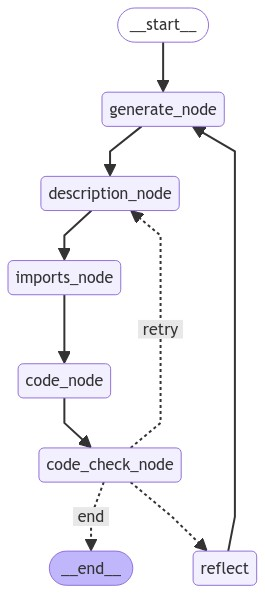

In [7]:
from IPython.display import Image

app = CodeAssistant(llm, context=concatenated_content) 
graph = app.compile()
Image(graph.get_graph().draw_mermaid_png())

## Example

In [52]:
app = CodeAssistant(llm, context=concatenated_content)
results = app.invoke("Write me a simple python code for retriever")

---GENERATING SOLUTION---
---GENERATING CODE DESCRIPTION---
---GENERATING IMPORTS BLOCK---
---GENERATING CODE BLOCK---


In [ ]:
# workflow = StateGraph(CodeState)

# # Define the nodes
# workflow.add_node("generate_node", generation_node)
# workflow.add_node("description_node", description_node)
# workflow.add_node("imports_node", imports_node)
# workflow.add_node("code_node", code_node)
# # workflow.add_node("reflect", reflect)

# # Build graph
# workflow.add_edge(START, "generate_node")
# workflow.add_edge("generate_node", "description_node")
# workflow.add_edge("description_node", "imports_node")
# workflow.add_edge("imports_node", "code_node")
# workflow.add_edge("code_node", END)
# # workflow.add_edge("code", "reflect")
# # workflow.add_conditional_edges(
# #     "check_code",
# #     decide_to_finish,
# #     {
# #         "end": END,
# #         "reflect": "reflect",
# #         "description": "description",
# #     },
# # )
# # workflow.add_edge("reflect", "generate")
# app = workflow.compile()

In [49]:
print(results['solution'])

Here is an example of how to combine a given question with retrieved context into a prompt for a LLM:

```python
from langchain_openai import ChatOpenAI
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

question = "What is the best way to learn Python?"
context = """Python is a high-level, interpreted programming language that is easy to learn and understand. It has a vast number of libraries and frameworks that make it suitable for various tasks such as web development, data analysis, artificial intelligence, etc.

Here are some tips on how to learn Python:

1. Start with the basics: Understand the syntax and basic concepts of Python.
2. Practice coding: The best way to learn any programming language is by writing code.
3. Use online resources: There are many online resources available that can help you learn Python, such as tutorials, videos, and documentation.

Remember, learning a programming language takes time

In [55]:
formatted_output = FormattedOutput(results)

In [58]:
print(results['code'])


Here is the code block without imports:

```
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
question = "What is the best way to learn Python?"
context = """Python is a high-level, interpreted programming language that is easy to learn and understand. It has a vast number of libraries and frameworks that make it suitable for various tasks such as web development, data analysis, machine learning, etc.

Some popular resources to learn Python include:

* Codecademy's Python Course
* Python.org (official Python documentation)
* W3Schools' Python Tutorial
* Udemy's Python courses

Additionally, you can also try practicing with online platforms like LeetCode, HackerRank, and Codewars.
"""
prompt = f"Answer this question using the provided context only.{question}Context:{context}"
llm(prompt)
```


In [57]:
print(formatted_output.code)


llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
question = "What is the best way to learn Python?"
context = """Python is a high-level, interpreted programming language that is easy to learn and understand. It has a vast number of libraries and frameworks that make it suitable for various tasks such as web development, data analysis, machine learning, etc.

Some popular resources to learn Python include:

* Codecademy's Python Course
* Python.org (official Python documentation)
* W3Schools' Python Tutorial
* Udemy's Python courses

Additionally, you can also try practicing with online platforms like LeetCode, HackerRank, and Codewars.
"""
prompt = f"Answer this question using the provided context only.{question}Context:{context}"
llm(prompt)

